In [187]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline

In [188]:
# Read in all the words
words = open('data/names.txt', 'r').read().splitlines()
print(words[:10])

# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

print(f'Character to index mapping: {itos}')
print(f'Vocabulary size: {vocab_size}')

# Shuffle the words
random.seed(42)
random.shuffle(words)


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Character to index mapping: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocabulary size: 27


In [190]:
# Encode the words with '.' so the model can learn when a name should end
def encode_words(words):
    encoded = []
    for w in words:
        encoded.extend([stoi[ch] for ch in '.' + w ])
    return encoded

encoded = encode_words(words)
encoded[:20]

[0, 25, 21, 8, 5, 14, 7, 0, 4, 9, 15, 14, 4, 18, 5, 0, 24, 1, 22, 9]

In [191]:
# Parameters for creating training and test sets
n = len(encoded)
n1 = int(0.8 * n)
block_size = 8
batch_size = 1

train_seq = encoded[:n1]
dev_seq = encoded[n1:]

In [192]:
def create_pairs(seq, block_size):
    X, Y = [], []
    for i in range(0, len(seq) - block_size, block_size):
        X.append(seq[i:i+block_size])
        Y.append(seq[i+1:i+block_size+1])
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    return X, Y

Xtr, Ytr = create_pairs(train_seq, block_size)
Xdev, Ydev = create_pairs(dev_seq, block_size)

In [193]:
# We are sure that we can pass in previous example's hidden layer
print(Xtr[1])
print(Ytr[1])
print(Xtr[2])
print(Ytr[2])
print(Xtr[3])
print(Ytr[3])
print(f'Training data shapes - X: {Xtr.shape}, Y: {Ytr.shape}')
print(f'Development data shapes - X: {Xdev.shape}, Y: {Ydev.shape}')

tensor([ 4.,  9., 15., 14.,  4., 18.,  5.,  0.])
tensor([ 9., 15., 14.,  4., 18.,  5.,  0., 24.])
tensor([24.,  1., 22.,  9.,  5., 14.,  0., 10.])
tensor([ 1., 22.,  9.,  5., 14.,  0., 10., 15.])
tensor([15., 18.,  9.,  0., 10., 21.,  1., 14.])
tensor([18.,  9.,  0., 10., 21.,  1., 14., 12.])
Training data shapes - X: torch.Size([22814, 8]), Y: torch.Size([22814, 8])
Development data shapes - X: torch.Size([5703, 8]), Y: torch.Size([5703, 8])


In [228]:
lr = 0.001
batch_size = 1
hidden_size = 30
time_steps = 8
input_size = 27

In [199]:
# def softmax(x):
#     e_x = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
#     return e_x / torch.sum(e_x, dim=1, keepdim=True)

def softmax(x):
    e_x = torch.exp(x)
    return e_x / torch.sum(e_x, dim=1, keepdim=True)

In [197]:
# Initalize parameters
Fvh = torch.randn(vocab_size, hidden_size) * 0.01
i1vh = torch.randn(vocab_size, hidden_size) * 0.01
i2vh = torch.randn(vocab_size, hidden_size) * 0.01
Ovh = torch.randn(vocab_size, hidden_size) * 0.01

Fhh = torch.randn(hidden_size, hidden_size) * 0.01
i1hh = torch.randn(hidden_size, hidden_size) * 0.01
i2hh = torch.randn(hidden_size, hidden_size) * 0.01
Ohh = torch.randn(hidden_size, hidden_size) * 0.01

bias1 = torch.zeros(1, hidden_size)
bias2 = torch.zeros(1, hidden_size)
bias3 = torch.zeros(1, hidden_size)
bias4 = torch.zeros(1, hidden_size)

output_matrix = torch.randn(hidden_size, vocab_size) * 0.01
output_bias = torch.zeros(1, vocab_size)

X = {}
H = {}
C = {}
Ct = {}
preact1 = {}
preact2 = {}
preact3 = {}
preact4 = {}
act1 = {}
act2 = {}
act3 = {}
act4 = {}
logits = {}

In [201]:
def sample(hprev, cprev, seed_ix, n):
    # Create one hot vector based on input seed_ix
    x = torch.zeros(1, vocab_size)
    x[0, seed_ix] = 1
    ixes = []

    for t in range(n):
        # Forward propogation again
        preact1 = x @ Fvh + hprev @ Fhh + bias1 # (1, 27) @ (27, 30) + (1, 30) @ (30, 30) + (30) = (1, 30)
        preact2 = x  @ i1vh + hprev  @ i1hh * bias2 # (32, 27) @ (27, 30) + (32, 30) @ (30, 30) + (30)
        preact3 = x  @ i2vh + hprev  @ i2hh + bias3 # (32, 27) @ (27, 30) + (32, 30) @ (30, 30) + (30)
        preact4 = x  @ Ovh + hprev  @ Ohh + bias4 # (32, 27) @ (27, 30) + (32, 30) @ (30, 30) + (30)
        act1 = torch.sigmoid(preact1) # (1, 30)
        act2 = torch.sigmoid(preact2) # (1, 30)
        act3 = torch.tanh(preact3) # (1, 30)
        act4 = torch.sigmoid(preact4) # (1, 30)
        C = act1 * cprev  + act2  * act3  # (1, 30)
        Ct = torch.tanh(C) # (1, 30)
        H = Ct * act4  # (1, 30)          
        logits = H  @ output_matrix + output_bias # (1, 30) @ (30, 27) + (1, 27) = (1, 27)

        # Probability
        counts = logits.exp()
        counts_sum = counts.sum(1, keepdims=True)
        counts_sum_inv = counts_sum**-1
        probs = counts * counts_sum_inv

        # Sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        if (ix == 0):
            break
        ixes.append(ix)

        # Update our parameters
        x = torch.zeros(1, vocab_size)
        x[0, ix] = 1
        hprev = H
        cprev = C
    return ixes

In [275]:
max_iterations = 0
max_iterations_limit = 10000000

while max_iterations < max_iterations_limit:
    
    # Looping over batches (each batch is just a single row)
    for batch_num in range(Xtr.shape[0]):

        # Initial cell state and hidden state and loss
        if (max_iterations == 0):
            H[-1] = torch.zeros(1, hidden_size)
            C[-1] = torch.zeros(1, hidden_size)
        loss = 0   
        
        # Get a batch of random numbers into correct shape
        # Get corresponding row from training set
        Xb = Xtr[batch_num, :].to(torch.long) # (1, 8)
        # Conver to one hot vectors
        Xb = F.one_hot(Xb, 27).float() # (8, 27)
        # Get corresponding row from training set
        Yb = Ytr[batch_num].to(torch.long) # (8, 1)
        
### --------------------------------------------------------------------------------------------------------------        
        # Forward pass over all time steps
        for t in range(time_steps):
            # Pass through weight matrices (last hidden activations and current time step's input)
            # This means that there is one less hidden layer than the number of activations inputted
            # Xb[t] gets a single row from the training set
            preact1[t] = Xb[t] @ Fvh + H[t-1] @ Fhh + bias1 # (1, 27) @ (27, 30) + (1, 30) @ (30, 30) + (30) = (1, 30)
            preact2[t] = Xb[t]  @ i1vh + H[t-1]  @ i1hh * bias2 # (32, 27) @ (27, 30) + (32, 30) @ (30, 30) + (30)
            preact3[t] = Xb[t]  @ i2vh + H[t-1]  @ i2hh + bias3 # (32, 27) @ (27, 30) + (32, 30) @ (30, 30) + (30)
            preact4[t] = Xb[t]  @ Ovh + H[t-1]  @ Ohh + bias4 # (32, 27) @ (27, 30) + (32, 30) @ (30, 30) + (30)

            # Compute activations
            act1[t] = torch.sigmoid(preact1[t]) # (1, 30)
            act2[t] = torch.sigmoid(preact2[t]) # (1, 30)
            act3[t] = torch.tanh(preact3[t]) # (1, 30)
            act4[t] = torch.sigmoid(preact4[t]) # (1, 30)
            
            # Forget gate * previous cell state + i1 gate * i2 gate
            C[t] = act1[t] * C[t-1]  + act2[t]  * act3[t]  # (1, 30)
            Ct[t] = torch.tanh(C[t]) # (1, 30)
            # Compute current time step's hidden output to be passed onto the next time step
            H[t] = Ct[t] * act4[t]  # (1, 30)          

            # Logits
            logits[t] = H[t]  @ output_matrix + output_bias # (1, 30) @ (30, 27) + (1, 27) = (1, 27)

            # Cross entropy
            counts = logits[t].exp()
            counts_sum = counts.sum(1, keepdims=True)
            counts_sum_inv = counts_sum**-1
            probs = counts * counts_sum_inv
            logprobs = probs.log()
            loss += -logprobs[0, Yb[t]]

        # Continue the sequence for time step -1 of the next input sequence by passing it on
        H[-1] = H[time_steps - 1]
        C[-1] = C[time_steps - 1]

        # Print out the loss occasionally, and sample from the model occassionally
        if max_iterations % 1000 == 0:
            print("loss: ", loss)
            print("iteration: ", max_iterations)
            # Pass in the last hidden layer, and last cell state
            # Pass in the index which can be referenced through itos
            for i in range(5):
                sample_ix = sample(hprev, cprev, 0, 15)
                txt = ''.join(itos[ix] for ix in sample_ix)
                print('----\n %s \n----' % (txt,))

        # Increment max iterations (each training example means one iteration)
        max_iterations += 1
        
        if max_iterations >= max_iterations_limit:
            break

### ---------------------------------------------------------------------------------------------------------------
        # Backward pass
        # Set to zeros initially
        dHnext = torch.zeros_like(H[0])
        dCnext = torch.zeros_like(C[0])
        
        dFvh = torch.zeros(vocab_size, hidden_size)
        di1vh = torch.zeros(vocab_size, hidden_size)
        di2vh = torch.zeros(vocab_size, hidden_size)
        dOvh = torch.zeros(vocab_size, hidden_size)
        
        dFhh = torch.zeros(hidden_size, hidden_size)
        di1hh = torch.zeros(hidden_size, hidden_size)
        di2hh = torch.zeros(hidden_size, hidden_size)
        dOhh = torch.zeros(hidden_size, hidden_size)
        
        dbias1 = torch.zeros(1, hidden_size)
        dbias2 = torch.zeros(1, hidden_size)
        dbias3 = torch.zeros(1, hidden_size)
        dbias4 = torch.zeros(1, hidden_size)
        
        doutput_matrix = torch.zeros(hidden_size, vocab_size)
        doutput_bias = torch.zeros(1, vocab_size)

        for t in reversed(range(time_steps)):
            # Backpropogate cross entropy
            dlogits = F.softmax(logits[t], 1)
            dlogits [0, Yb[t]] -= 1
            
            # Backpropogate output matrix and its bias
            doutput_matrix +=  H[t].T @ dlogits # (30, 1) @ (1, 27) = (30, 27)
            doutput_bias += dlogits # (1, 27)
            
            # Backpropogate into H (two derivatives due to 2 dependencies)
            dH = dlogits  @ output_matrix.T + dHnext # (1, 27) @ (27, 30) + (1, 30) = (1, 30)
            
            # Backpropogate dact4 (output gate activations)
            dact4  = dH  * Ct[t]  # (1, 30) * (1, 30) = (1, 30)
            
            # Backpropogate dC (current cell state and also two derivatives)
            dC = dH * act4[t] * (1 - torch.tanh(C[t]) ** 2) + dCnext # (1, 30) * (1, 30) * (1, 30) = (1, 30)
            
            ### Backpropogate act1 and previous cell state
            # Forget gate activations
            # dCnext activations
            dact1 = dC * C[t-1] # (1, 30) * (1, 30) = (1, 30)
            dCnext = dC * act1[t]
            
            # Backpropogate i1 activations
            dact2  = dC  * act3[t] # (1, 27)
            
            # Backpropogate i2 activations
            dact3  = dC  * act2[t]  # (1, 27)
            
            # Backpropogate all preactivations
            dpreact1 = dact1 * act1[t] * (1 - act1[t])
            dpreact2 = dact2 * act2[t] * (1 - act2[t])
            dpreact3 = dact3 * (1 - torch.tanh(preact3[t]) ** 2)
            dpreact4 = dact4 * act4[t] * (1 - act4[t])
            
            # Backpropogate gates
            dFvh += Xb[t].reshape(vocab_size, 1) @ dpreact1  # (27, 1) (1, 30) = (27, 30)
            dFhh += H[t-1].reshape(hidden_size, 1) @ dpreact1  # (30, 1) (1, 30) = (30, 30)
            dbias1 += dpreact1
            
            di1vh += Xb[t].reshape(vocab_size, 1) @ dpreact2 # (27, 1) (1, 30) = (27, 30)
            di1hh += H[t-1].reshape(hidden_size, 1) @ dpreact2 # (30, 1) (1, 30) = (30, 30)
            dbias2 += dpreact2
            
            di2vh += Xb[t].reshape(vocab_size, 1) @ dpreact3 # (27, 1) (1, 30) = (27, 30)
            di2hh += H[t-1].reshape(hidden_size, 1) @ dpreact3 # (30, 1) (1, 30) = (30, 30)
            dbias3 += dpreact3
            
            dOvh += Xb[t].reshape(vocab_size, 1) @ dpreact4 # (27, 1) (1, 30) = (27, 30)
            dOhh += H[t-1].reshape(hidden_size, 1) @ dpreact4 # (30, 1) (1, 30) = (30, 30)
            dbias4 += dpreact4
            
            # Backpropogate dHnext
            # (1, 30) @ (30, 30) ...  = (1, 30)
            dHnext  = dpreact1  @ Fhh.T + dpreact2  @ i1hh.T + dpreact3  @ i2hh.T + dpreact4  @ Ohh.T

        # torch.nn.utils.clip_grad_norm_([dFvh, di1vh, di2vh, dOvh, dFhh, di1hh, di2hh, dOhh, dbias1, dbias2, dbias3, dbias4, doutput_matrix, doutput_bias], max_norm=1.0)

### ------------------------------------------------------------------------------------------------------------------
    
        # Update parameters using gradients
        Fvh -= lr * dFvh
        i1vh -= lr * di1vh
        i2vh -= lr * di2vh
        Ovh -= lr * dOvh

        Fhh -= lr * dFhh
        i1hh -= lr * di1hh
        i2hh -= lr * di2hh
        Ohh -= lr * dOhh
        
        bias1 -= lr * dbias1
        bias2 -= lr * dbias2
        bias3 -= lr * dbias3
        bias4 -= lr * dbias4

        output_matrix -= lr * doutput_matrix
        output_bias -= lr * doutput_bias

    

loss:  tensor(22.6358)
iteration:  0
----
 chsariean 
----
----
 tiono 
----
----
 mirkliea 
----
----
 jahvis 
----
----
 erflix 
----
loss:  tensor(17.5541)
iteration:  1000
----
 anivan 
----
----
 zade 
----
----
 amdir 
----
----
 mill 
----
----
 yohuxfa 
----
loss:  tensor(19.1856)
iteration:  2000
----
 nillis 
----
----
 wasan 
----
----
 stattin 
----
----
 tyuntynn 
----
----
 adarue 
----
loss:  tensor(20.9991)
iteration:  3000
----
 ola 
----
----
 viman 
----
----
 semiah 
----
----
 dani 
----
----
 karis 
----
loss:  tensor(15.4757)
iteration:  4000
----
 dare 
----
----
 caeliah 
----
----
 deonn 
----
----
 zame 
----
----
 jaishy 
----
loss:  tensor(23.9158)
iteration:  5000
----
 yani 
----
----
 dedryn 
----
----
 aylon 
----
----
 doriah 
----
----
 suahan 
----
loss:  tensor(20.9243)
iteration:  6000
----
 jaci 
----
----
 britigh 
----
----
 honno 
----
----
 corlatis 
----
----
 aumaria 
----
loss:  tensor(20.3049)
iteration:  7000
----
 millen 
----
----
 kasa

KeyboardInterrupt: 

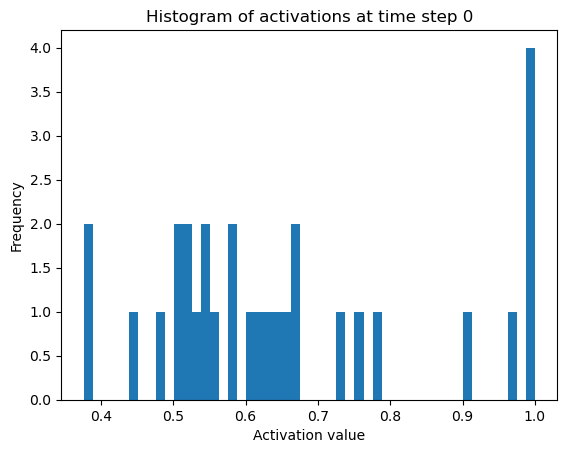

In [276]:
plt.hist(act2[5].view(-1).tolist(), bins=50)
plt.title('Histogram of activations at time step 0')
plt.xlabel('Activation value')
plt.ylabel('Frequency')
plt.show()

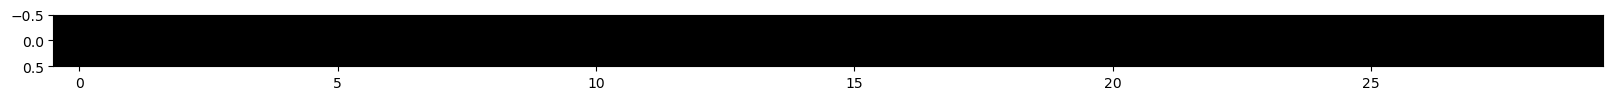

In [274]:
# Saturated activations
plt.figure(figsize = (20,50))
plt.imshow(act2[2].abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

activation  0  --------------------------------------------------
time step 0
mean: 0.30761024355888367
std: 0.24636179208755493
saturated: 0.0%
time step 1
mean: 0.4671536982059479
std: 0.1751863956451416
saturated: 0.0%
time step 2
mean: 0.486298531293869
std: 0.14784404635429382
saturated: 0.0%
time step 3
mean: 0.4898031949996948
std: 0.16202980279922485
saturated: 0.0%
time step 4
mean: 0.512763261795044
std: 0.1740703135728836
saturated: 0.0%
time step 5
mean: 0.5204014778137207
std: 0.25065746903419495
saturated: 0.0%
time step 6
mean: 0.4006092846393585
std: 0.2875804603099823
saturated: 6.666667014360428%
time step 7
mean: 0.32402461767196655
std: 0.22943371534347534
saturated: 0.0%
activation  1  --------------------------------------------------
time step 0
mean: 0.4924177825450897
std: 0.2871716022491455
saturated: 3.333333507180214%
time step 1
mean: 0.38154274225234985
std: 0.27503612637519836
saturated: 0.0%
time step 2
mean: 0.4142678678035736
std: 0.196896493434906
sat

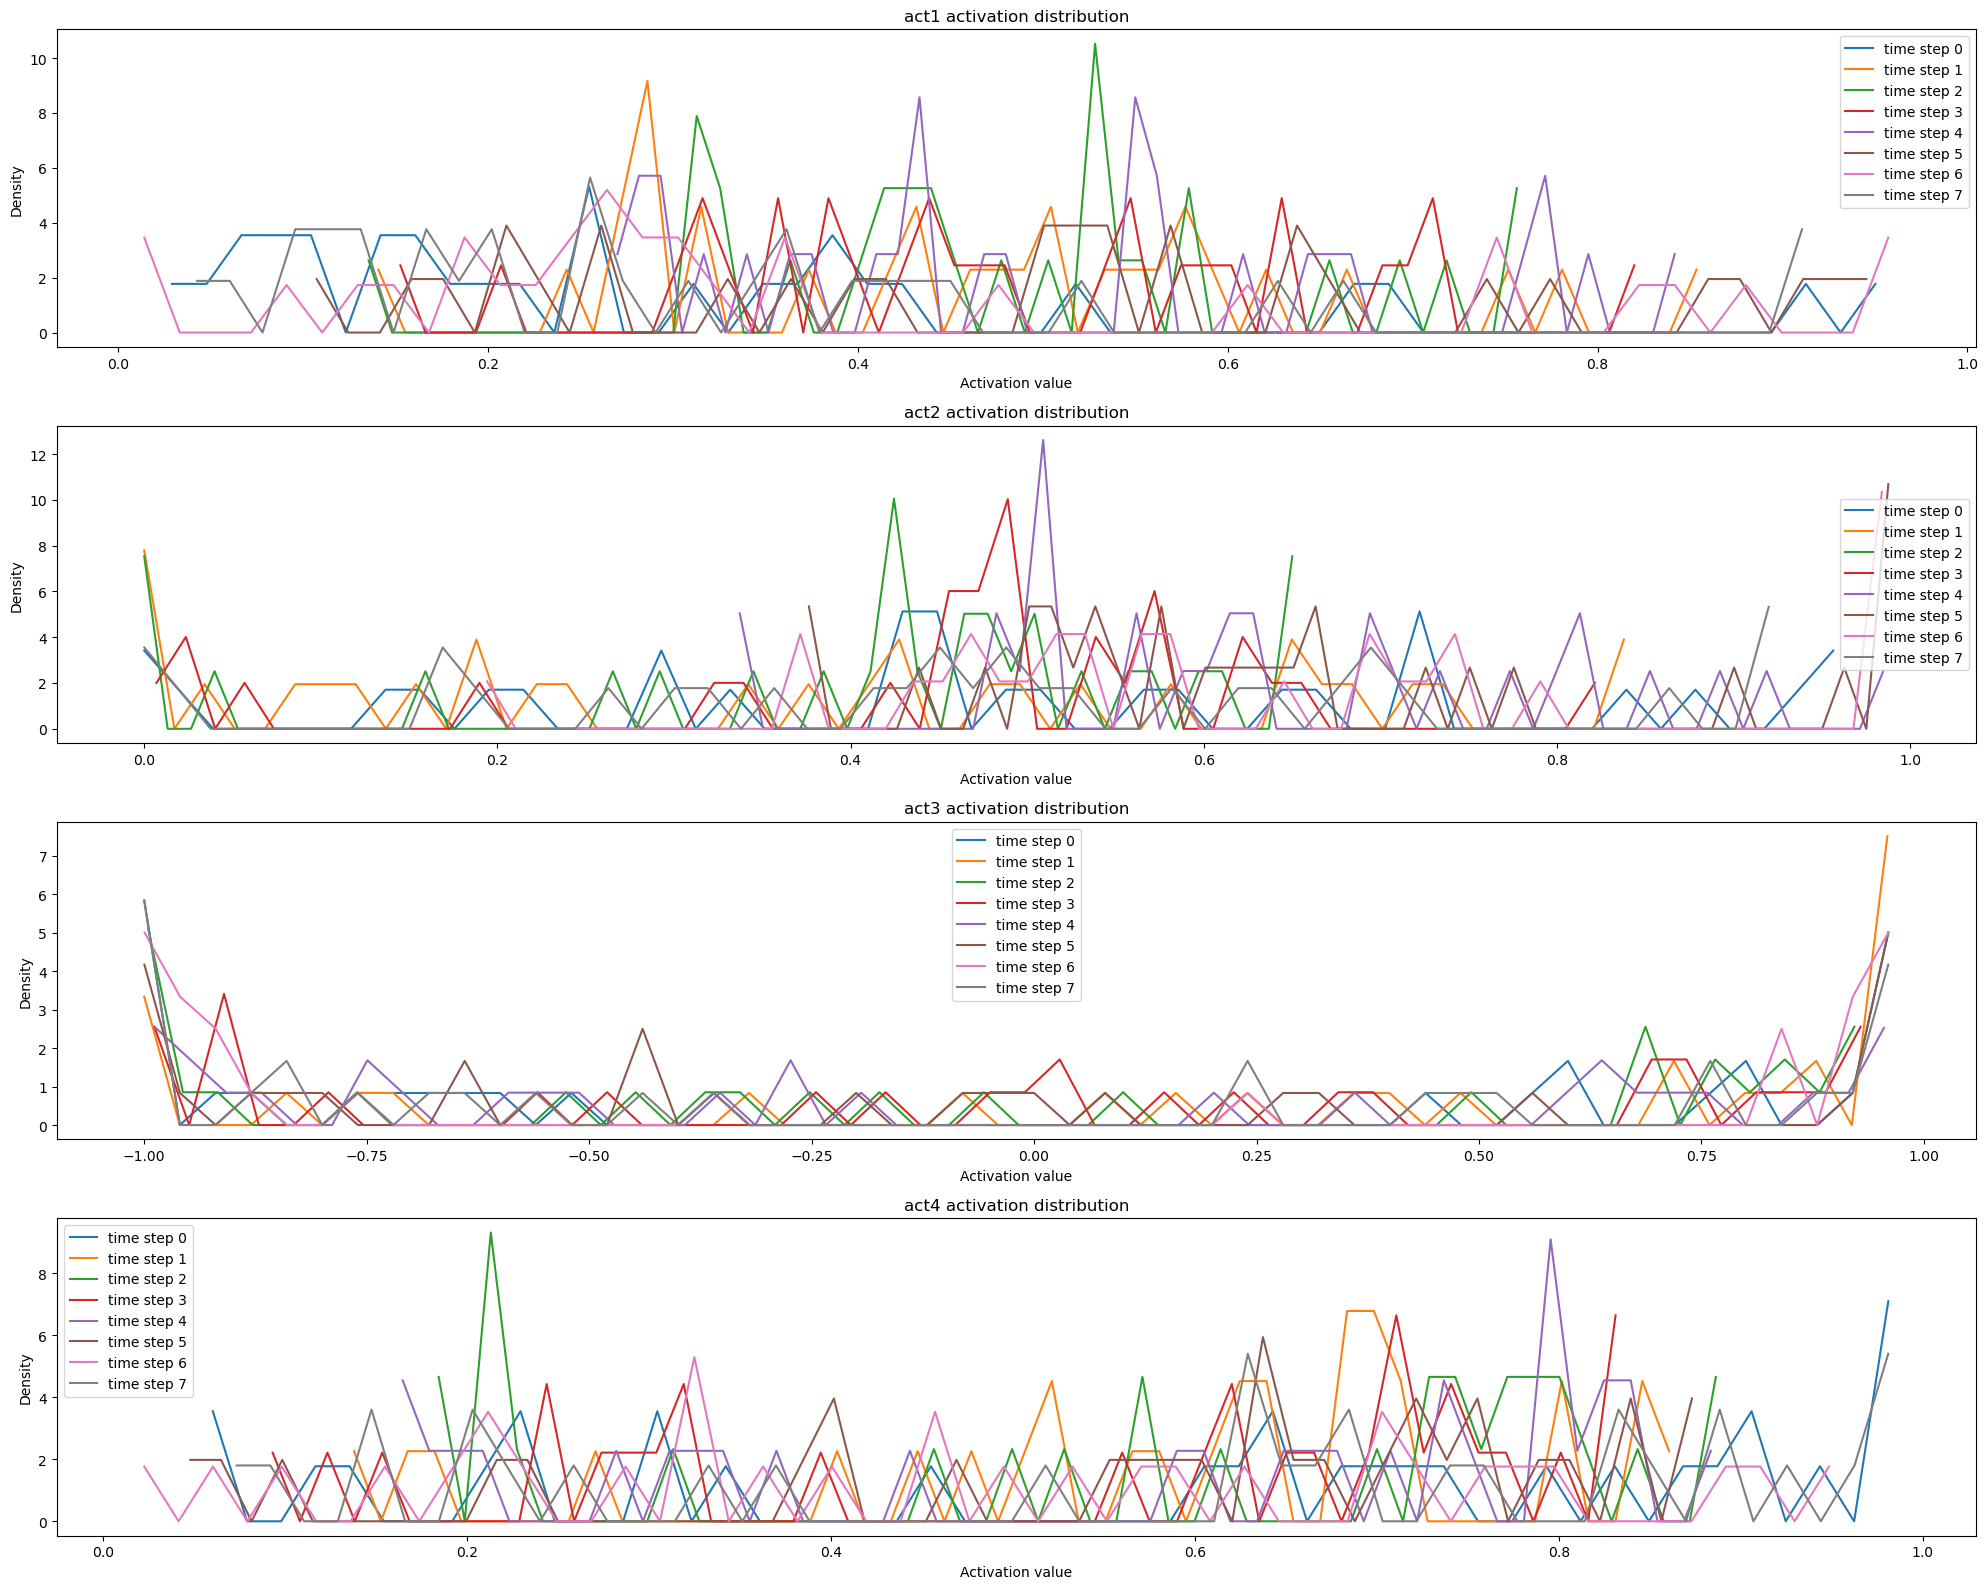

In [297]:
# Assuming act1, act2, act3, and act4 are your activations tensors
activations = [act1, act2, act3, act4]
activation_names = ["act1", "act2", "act3", "act4"]

plt.figure(figsize=(20, 16))  # Width and height of the plot

for i, act in enumerate(activations):
    print("activation ", i, " --------------------------------------------------")
    plt.subplot(4, 1, i+1)  # Create a subplot for each set of activations
    legends = []
    for t in range(time_steps):  # Loop over all time steps
        activations_at_t = act[t]
        print(f"time step {t}")
        print(f"mean: {activations_at_t.mean().item()}")
        print(f"std: {activations_at_t.std().item()}")
        print(f"saturated: {(activations_at_t.abs() > 0.97).float().mean().item()*100}%")
        
        hy, hx = torch.histogram(activations_at_t.view(-1), bins=50, density=True)
        plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
        legends.append(f'time step {t}')
    
    plt.legend(legends)
    plt.title(f'{activation_names[i]} activation distribution')
    plt.xlabel('Activation value')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [232]:
hprev = torch.zeros(1, hidden_size)
cprev = torch.zeros(1, hidden_size)
num_samples = 10
for i in range(num_samples):
    sample_ix = sample(hprev, cprev, 0, 15)
    txt = ''.join(itos[ix] for ix in sample_ix)
    print('----\n %s \n----' % (txt,))


----
 ani 
----
----
 elon 
----
----
 kayla 
----
----
 kaia 
----
----
 haet 
----
----
 liany 
----
----
 azdad 
----
----
 soralee 
----
----
 bannaby 
----
----
 youraabalyne 
----


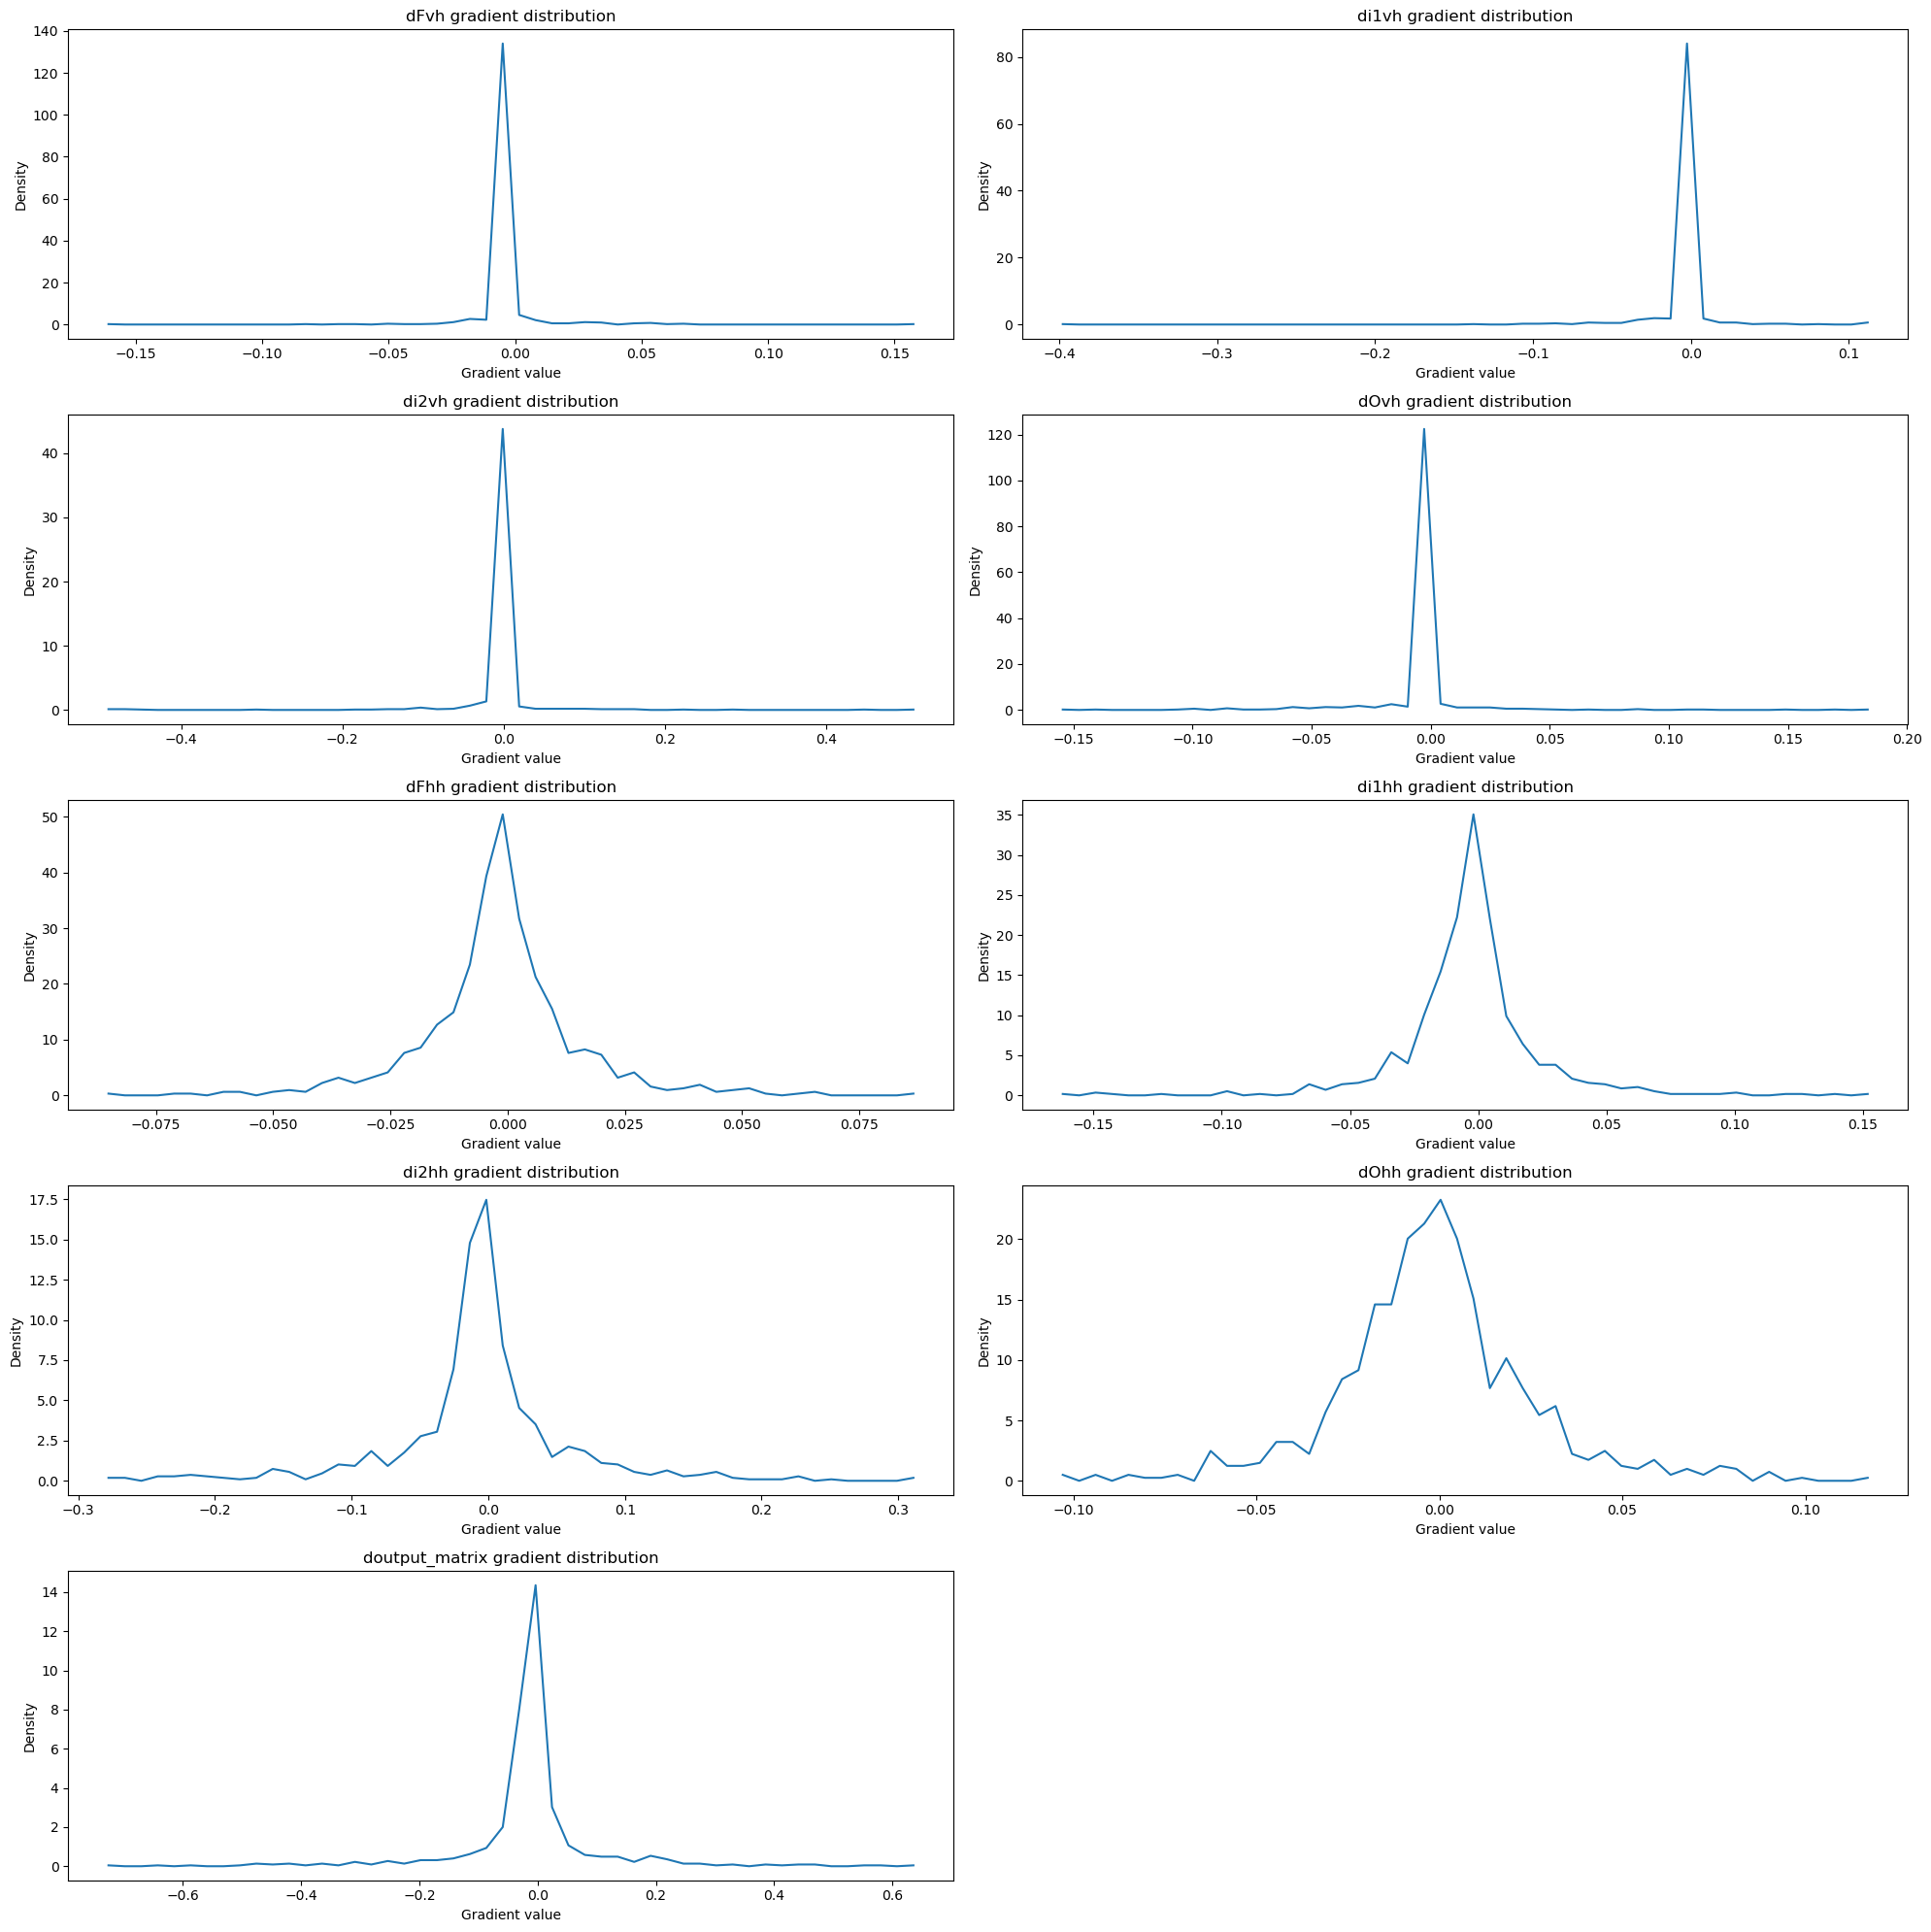

In [299]:
# Assuming the gradients dFvh, di1vh, di2vh, dOvh, dFhh, di1hh, di2hh, dOhh, and doutput_matrix are defined as tensors
gradients = [dFvh, di1vh, di2vh, dOvh, dFhh, di1hh, di2hh, dOhh, doutput_matrix]
gradient_names = ["dFvh", "di1vh", "di2vh", "dOvh", "dFhh", "di1hh", "di2hh", "dOhh", "doutput_matrix"]

plt.figure(figsize=(20, 20))  # Adjust the size as needed

for i, grad in enumerate(gradients):
    plt.subplot(5, 2, i+1)  # Create a subplot for each gradient, arranging in 5 rows and 2 columns
    grad_flattened = grad.view(-1)  # Flatten the gradient tensor to 1D
    hy, hx = torch.histogram(grad_flattened, bins=50, density=True)
    plt.plot(hx[:-1].detach().cpu(), hy.detach().cpu())
    plt.title(f'{gradient_names[i]} gradient distribution')
    plt.xlabel('Gradient value')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()
